### Extraction of major peaks P-Q-R-S-T and relative time intervals


In [99]:
import copy
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

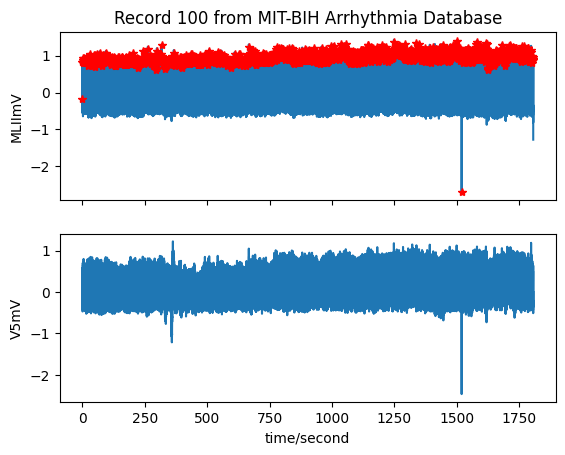

In [100]:
# Extract data from files

# Samples from the original data to load
SAMPLE_NUM = 30000

#record = wfdb.rdrecord('src/mitdb/100', sampto = SAMPLE_NUM)
#annotation = wfdb.rdann('src/mitdb/100', 'atr', sampto = SAMPLE_NUM)

record = wfdb.rdrecord('src/mitdb/100')
annotation = wfdb.rdann('src/mitdb/100', 'atr')

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds')
#display(record.__dict__)
#display(annotation.__dict__)


In [101]:
# Convert annotations to useful ones

# Read symbols and substitute them
# Classes:  'N': Normal beat
#           'S': Supraventricular premature
#           'V': Premature ventricular contraction
#           'F': Fusion of ventricular and normal beat
#           'Q': Unclassifiable
symbol_dict = { 'N':'N',
                'S':'S', 'A':'S', 'a':'S', 'J':'S', 'e':'S', 'j':'S', 'x':'S',
                'V':'V', 'L':'V', 'R':'V', 'E':'V', '[':'V', '!':'V', ']':'V',
                'F':'F', 'f':'F',
                'Q':'Q', '/':'Q', '|':'Q'}

raw_ann_symbol = annotation.symbol.copy()
raw_ann_symbol = [symbol_dict[key] if key in symbol_dict else key for key in raw_ann_symbol]
del raw_ann_symbol[0]

print(raw_ann_symbol)

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

In [102]:
# Sampling frequency
#FREQ_SAMPLE = 360
#FREQ_SAMPLE = 1

# Extract ECG data array
v_data = record.p_signal
v_data = v_data[:,0]

# Define time array (Fs:360Hz)
v_time = np.arange(0, v_data.size, 1, dtype=int)
#v_time = np.round(v_time/FREQ_SAMPLE, 3)

# Extract annotations array
v_ann = np.zeros(shape=(v_data.size,1), dtype=str)
for i in range(len(annotation.sample)):
    v_ann[(annotation.sample)[i]] = annotation.symbol[i]


In [103]:
# Zeros array for x-axis

axis_x = np.zeros_like(v_data)

In [104]:
# Signal filtering

# Apply lowpass filter
# Difference equation:
# y(nT) = 2y(nT-T) - y(nT-2T) + x(nT) - 2x(nT-5T) + x(nT-10T)

x = np.ones_like(v_data)*v_data
for i in range(0,15):
    x[i] = 0
y = np.zeros_like(v_data)
for i in range(12, len(y)):
    y[i] = 2*y[i-1] - y[i-2] + x[i] - 2*x[i-5] + x[i-10]
v_data_lp = np.copy(y)

# Apply highpass filter to obtain bandpass
# Difference equation:
# y(nT) = -x(nT)/32 + x(nT-16T) - x(nT-17T) + x(nT-32T)/32 + y(nT-1T)

x = np.copy(v_data_lp)
y = np.zeros_like(v_data_lp)
for i in range(35, len(y)):
    y[i] = -x[i]/32 + x[i-16] - x[i-17] + x[i-32]/32 + y[i-1]
v_data_bp = np.copy(y)

# Derivative filter
# Difference equation:
# y(nT) = 0.1(-x(nT-2T)) - 2x(nT-T) + 2x(nT+T) + x(nT+2T))

x = np.copy(v_data_bp)
y = np.zeros_like(v_data_bp)
for i in range(2, len(y)-2):
    y[i] = 0.1*(-x[i-2] - 2*x[i-1] + 2*x[i+1] + x[i+2])
v_data_der = np.copy(y)

# Squaring filter
# y(nT) = (x(nT)^2)

v_data_sq = v_data_der*v_data_der

In [105]:
# Moving average

# Window size for moving averages
WINDOW_TIME = 0.120 #ms
WINDOW_NUM = int(360*WINDOW_TIME)

v_data_avg = np.zeros_like(v_data)

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

tmp_avg = moving_average(v_data_sq, WINDOW_NUM)
v_data_avg = np.pad(tmp_avg, (WINDOW_NUM-1,0), 'constant', constant_values=(tmp_avg[0],0))

In [106]:
# Find R peaks
# R peaks are extracted from the annotation array
# R peaks are aligned to the original signal

v_peaks_R_time = annotation.sample
print(v_peaks_R_time)

v_peaks_R_data_raw = np.zeros_like(v_data)
for index in v_peaks_R_time:
    v_peaks_R_data_raw[index] = v_data[index]

v_peaks_R_data = v_peaks_R_data_raw[v_peaks_R_data_raw != 0]
print(v_peaks_R_data)

[    18     77    370 ... 649484 649734 649991]
[-0.17  0.84  0.94 ...  0.89  0.9   0.92]


In [107]:
# Calculate RR times

R_prev = 0
RR_time = 0
v_RR_time = np.zeros_like(v_peaks_R_time)

for i in range(len(v_peaks_R_time)):
    if (v_peaks_R_time[i] != 0):
        RR_time = v_peaks_R_time[i] - R_prev
        R_prev = v_peaks_R_time[i]
        v_RR_time[i] = RR_time

print(v_RR_time)

[ 18  59 293 ... 252 250 257]


In [108]:
# Find Q and S peaks

v_peaks_Q_time = np.zeros_like(v_peaks_R_time)
v_peaks_S_time = np.zeros_like(v_peaks_R_time)
v_peaks_Q_data = np.zeros(len(v_peaks_R_time), dtype=float)
v_peaks_S_data = np.zeros(len(v_peaks_R_time), dtype=float)

# Find Q and S times
for i in range(len(v_peaks_R_time)):
    # Find Q peak before current R time
    found_Q = False
    t = v_peaks_R_time[i]
    while found_Q is False:
        # Find a minumum
        if  ((v_data[t] <= v_data[t-1]) and (v_data[t] < v_data[t+1])):
            v_peaks_Q_time[i] = t
            found_Q = True
        t -= 1
    # Find S peak after current R time
    found_S = False
    t = v_peaks_R_time[i]
    while found_S is False:
        # Find a minumum
        if  ((v_data[t] <= v_data[t-1]) and (v_data[t] < v_data[t+1])):
            v_peaks_S_time[i] = t
            found_S = True
        if t==(len(v_data)-2):
            v_peaks_S_time[i] = t
            found_S = True
        else:
            t += 1

for i in range(len(v_peaks_R_data)):
    v_peaks_Q_data[i] = v_data[v_peaks_Q_time[i]]
    v_peaks_S_data[i] = v_data[v_peaks_S_time[i]]

In [109]:
# Define searching windows for P and T waves

v_area_t_min = np.zeros_like(v_peaks_R_time)
v_area_t_max = np.zeros_like(v_peaks_R_time)
v_area_p_min = np.zeros_like(v_peaks_R_time)
v_area_p_max = np.zeros_like(v_peaks_R_time)

for i in range(len(v_peaks_R_time)):
    if (v_peaks_R_time[i] != 0):
        curr_time = v_peaks_R_time[i]
        # Calculate time window and convert it to index offset
        #min_t = curr_time + int(0.12*v_RR_time[i]*FREQ_SAMPLE)
        #max_t = curr_time + int((0.57*v_RR_time[i]+0.060)*FREQ_SAMPLE)
        #min_p = curr_time - int(0.33*v_RR_time[i]*FREQ_SAMPLE)
        #max_p = curr_time - int((0.07*v_RR_time[i]+0.06)*FREQ_SAMPLE)
        min_t = curr_time + int(0.12*v_RR_time[i])
        max_t = curr_time + int((0.57*v_RR_time[i]+0.060))
        min_p = curr_time - int(0.33*v_RR_time[i])
        max_p = curr_time - int((0.07*v_RR_time[i]+0.06))
        #print("RR time: " + str(v_RR_time[i]) + "   min_j: " + str(min_j) + "   max_j: " + str(max_j))
        # Save area if window is not outside of signal
        if (max_t < v_peaks_R_time[-1]):
            for t in range(min_t, max_t):
                v_area_t_min[i] = min_t
                v_area_t_max[i] = max_t
        if (min_p > 0):
            for p in range(min_p, max_p):
                v_area_p_min[i] = min_p
                v_area_p_max[i] = max_p

v_area_p_min = v_area_p_min[v_area_p_min != 0]
v_area_p_max = v_area_p_max[v_area_p_max != 0]
v_area_t_min = v_area_t_min[v_area_t_min != 0]
v_area_t_max = v_area_t_max[v_area_t_max != 0]

#print(v_area_p_min)
#print(v_area_p_max)
#print(v_area_t_min)
#print(v_area_t_max)
        

In [110]:
# Apply Phasor Transform (see paper [3])
# R_v values:
#   0.001 for QRS
#   0.1 for T-wave
#   0.05 for P-wave

OFFSET = 20

v_phasor_qrs = np.arctan(v_data_bp/0.001)
v_phasor_t = np.arctan(v_data_bp/0.1)
v_phasor_p = np.arctan(v_data_bp/0.05)

v_peaks_P_time = np.zeros_like(v_area_p_max)
v_peaks_T_time = np.zeros_like(v_area_t_max)

# Find max values of phasors inside searching windows
for i in range(len(v_area_p_min)):
    v_peaks_P_time[i] = v_phasor_p[v_area_p_min[i]:v_area_p_max[i]].argmax(axis=0) + v_area_p_min[i] - OFFSET

for i in range(len(v_area_t_min)):
    v_peaks_T_time[i] = v_phasor_t[v_area_t_min[i]:v_area_t_max[i]].argmax(axis=0) + v_area_t_min[i] - OFFSET

print(v_peaks_P_time)


[    -7     52    321 ... 649436 649686 649941]


In [111]:
v_peaks_P_data = np.zeros_like(v_peaks_P_time, dtype=float)
v_peaks_T_data = np.zeros_like(v_peaks_T_time, dtype=float)

for i in range(len(v_peaks_P_data)):
    v_peaks_P_data[i] = v_data[v_peaks_P_time[i]]

for i in range(len(v_peaks_T_data)):
    v_peaks_T_data[i] = v_data[v_peaks_T_time[i]]

print(v_data)
print(v_peaks_P_data)

[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
[ 0.72  -0.285 -0.21  ... -0.155 -0.22  -0.335]


In [112]:
# Aggregate major points for each beat

v_total_data = np.zeros(shape=(len(v_peaks_R_time),9))
v_total_categ = np.empty(len(v_peaks_R_time), dtype=str)

for i in range(1, len(v_peaks_R_time)-1):
    v_total_data[i, 0] = v_peaks_R_data[i-1] - v_peaks_P_data[i-1]
    v_total_data[i, 1] = v_peaks_T_data[i-1] - v_peaks_R_data[i-1]
    v_total_data[i, 2] = v_peaks_P_data[i] - v_peaks_T_data[i-1]
    v_total_data[i, 3] = v_peaks_R_data[i] - v_peaks_P_data[i]
    v_total_data[i, 4] = v_peaks_T_data[i] - v_peaks_R_data[i]
    v_total_data[i, 5] = v_RR_time[i]
    v_total_data[i, 6] = v_peaks_R_time[i] - v_peaks_P_time[i]
    v_total_data[i, 7] = v_peaks_T_time[i] - v_peaks_R_time[i]

    v_total_categ[i] = raw_ann_symbol[i]

print(v_total_data)
print(v_total_categ)

[[ 0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [-8.900e-01  2.500e-02 -1.400e-01 ...  2.500e+01  0.000e+00  0.000e+00]
 [ 1.125e+00  0.000e+00 -1.050e+00 ...  4.900e+01  1.180e+02  0.000e+00]
 ...
 [ 1.050e+00 -1.160e+00  9.500e-02 ...  4.800e+01  1.100e+02  0.000e+00]
 [ 1.045e+00 -1.160e+00  5.000e-02 ...  4.800e+01  1.110e+02  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]]
['' 'N' 'N' ... 'N' 'N' '']


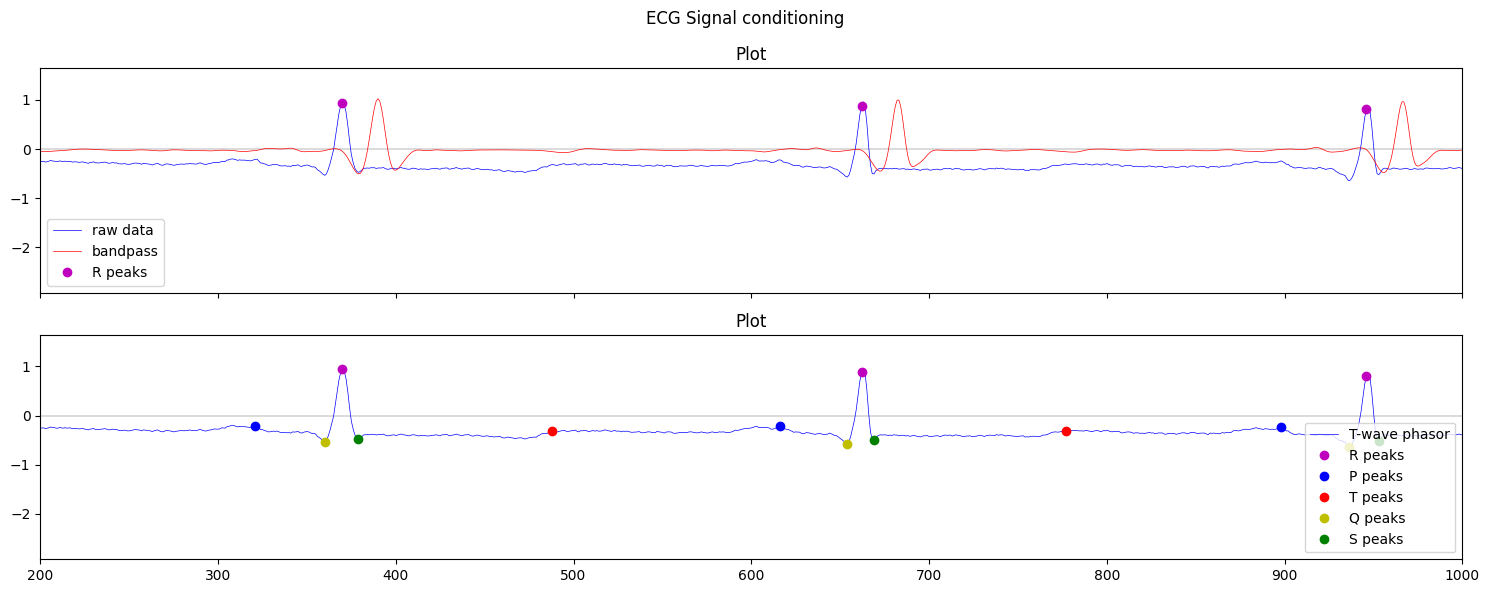

In [115]:
# Plotting window
X_MIN = 200
X_MAX = 1000
N_ROW = 2

n = 0
# Create plots
fig, axs = plt.subplots(N_ROW, 1, sharex=True)
fig.set_size_inches(15, 3*N_ROW)
fig.suptitle("ECG Signal conditioning")
axs[n].set_xlim(X_MIN, X_MAX)

# First plot
axs[n].title.set_text('Plot')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="raw data", linewidth=0.5)
axs[n].plot(v_time, v_data_bp/20, 'r', label="bandpass", linewidth=0.5)
axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
axs[n].legend()
n += 1

# Second plot
axs[n].title.set_text('Plot')
axs[n].plot(v_time, axis_x, linewidth=0.2, color="black")
axs[n].plot(v_time, v_data, 'b', label="T-wave phasor", linewidth=0.5)
axs[n].plot(v_peaks_R_time, v_peaks_R_data, 'mo', label="R peaks", linewidth=0.5)
axs[n].plot(v_peaks_P_time, v_peaks_P_data, 'bo', label="P peaks", linewidth=0.5)
axs[n].plot(v_peaks_T_time, v_peaks_T_data, 'ro', label="T peaks", linewidth=0.5)
axs[n].plot(v_peaks_Q_time, v_peaks_Q_data, 'yo', label="Q peaks", linewidth=0.5)
axs[n].plot(v_peaks_S_time, v_peaks_S_data, 'go', label="S peaks", linewidth=0.5)
axs[n].legend()
n += 1

plt.tight_layout()
plt.show()